In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.tools import diff
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset

import warnings
warnings.filterwarnings("ignore")

In [9]:
sale_df = pd.read_excel('DS3_C6_S4_TimeSeries_Sales_Data_Project.xls',index_col='Order Date',parse_dates=True)
sale_df.head()

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,,
2016-11-08,1,CA-2016-152156,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2016-11-08,2,CA-2016-152156,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2016-06-12,3,CA-2016-138688,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
2015-10-11,4,US-2015-108966,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
2015-10-11,5,US-2015-108966,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Exploratory Data Analysis

In [10]:
sale_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9994 entries, 2016-11-08 to 2017-05-04
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Ship Date      9994 non-null   datetime64[ns]
 3   Ship Mode      9994 non-null   object        
 4   Customer ID    9994 non-null   object        
 5   Customer Name  9994 non-null   object        
 6   Segment        9994 non-null   object        
 7   Country        9994 non-null   object        
 8   City           9994 non-null   object        
 9   State          9994 non-null   object        
 10  Postal Code    9994 non-null   int64         
 11  Region         9994 non-null   object        
 12  Product ID     9994 non-null   object        
 13  Category       9994 non-null   object        
 14  Sub-Category   9994 non-null   object        
 15  Pro

In [11]:
cat =  ['Ship Mode', 'Segment', 'Country', 'Region','State', 'Category']
cont =  ['Row ID' ,'Sales', 'Profit', 'Quantity', 'Discount']

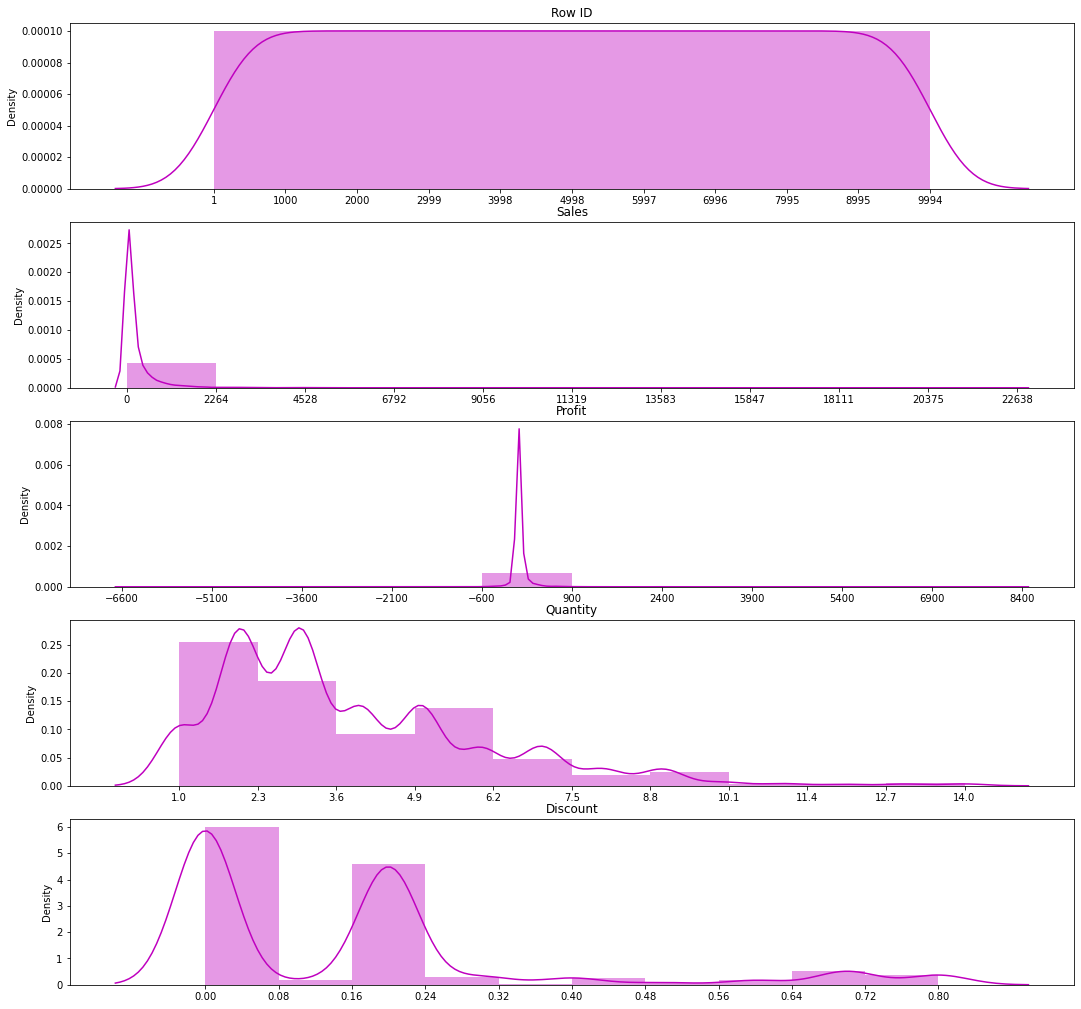

In [44]:
l=list(enumerate(cont))
plt.figure(figsize=(18,36))
for x in l:
    plt.subplot(10,1,x[0]+1)
    sns.distplot(x=sale_df[x[1]],bins=10,color='m')
    plt.xticks(np.linspace(min(sale_df[x[1]]),max(sale_df[x[1]]),11)) 
    plt.title(x[1])
plt.show()

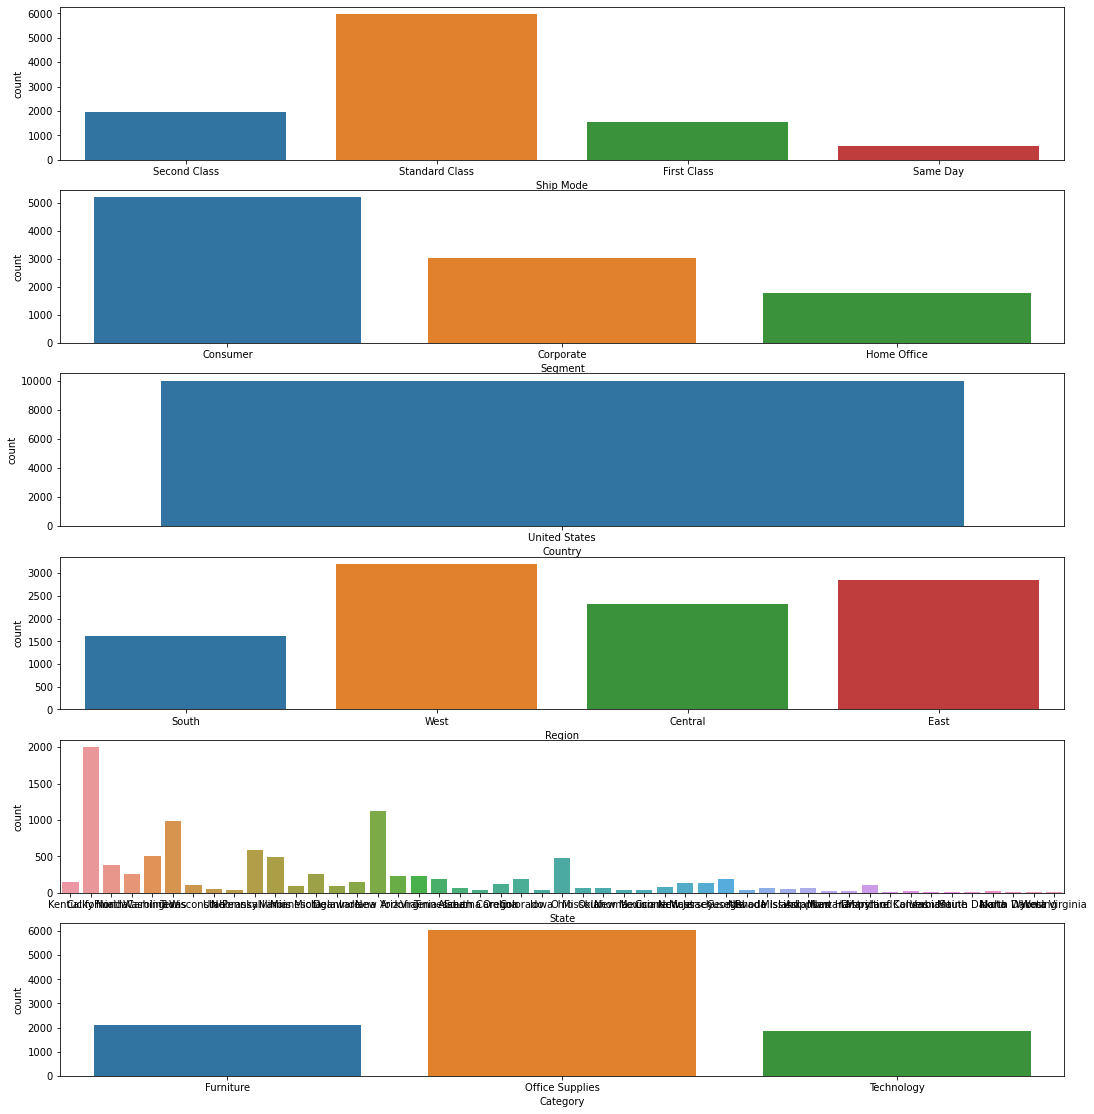

In [14]:
m=list(enumerate(cat))
plt.figure(figsize=(18,50))
for x in m:
    plt.subplot(15,1,x[0]+1)
    sns.countplot(x=sale_df[x[1]]) 
plt.show()

In [15]:
sales=sale_df['Sales'].resample('M').mean()
sales.head()

Order Date
2014-01-31    180.213861
2014-02-28     98.258522
2014-03-31    354.719803
2014-04-30    209.595148
2014-05-31    193.838418
Freq: M, Name: Sales, dtype: float64

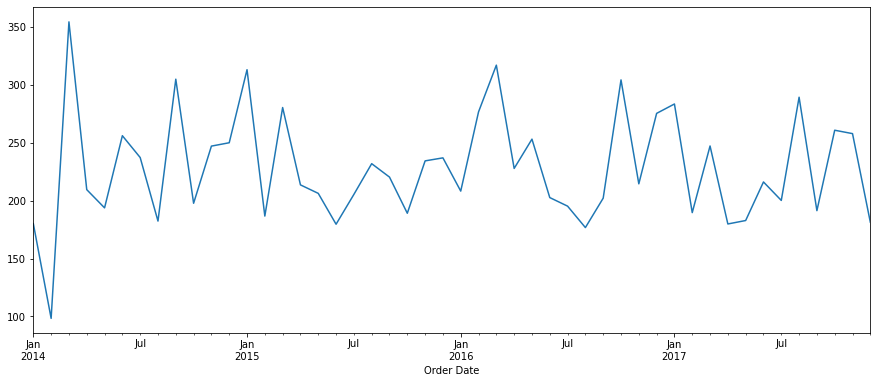

In [16]:
sales.plot(figsize=(15, 6));

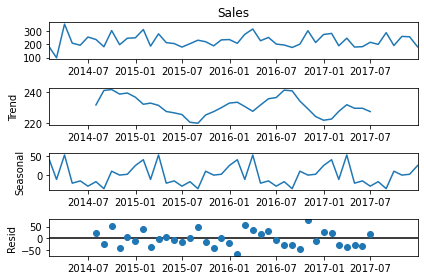

In [17]:
decomposition = sm.tsa.seasonal_decompose(sales, model='additive')
decomposition.plot()
plt.show()

In [18]:
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    
    if pvalue < 0.05:
        msg = "pvalue={}. Data is stationary".format(pvalue)
    else:
        msg = "pvalue={}. Data is not stationary".format(pvalue)
    return msg

In [19]:
checkStationarity(sales)

'pvalue=0.015489720191097667. Data is stationary'

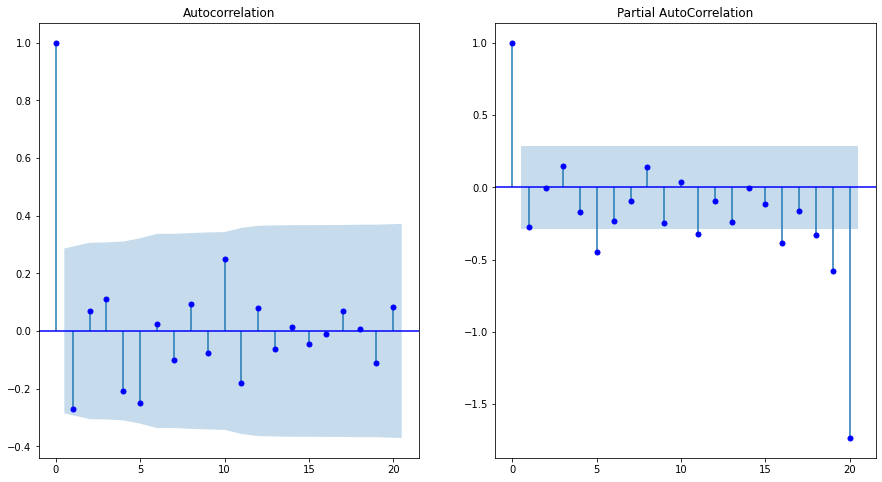

In [20]:
ROWS=1; COLS=2
fig,ax=plt.subplots(ROWS,COLS,figsize=(15,8))
plot_acf(sales[1:],lags=20,ax=ax[0], color='blue')
plt.title("AutoCorrelation")
plot_pacf(sales[1:],lags=20,ax=ax[1], color='blue')
plt.title("Partial AutoCorrelation");

In [21]:
ss= int(0.7 * len(sales))
df_train, df_test = sales[:ss], sales[ss:]
print('Train-Dataset: %d, Test-Dataset: %d' % (len(df_train), len(df_test)))

Train-Dataset: 33, Test-Dataset: 15


In [22]:
p=[1,2,3,4]
q=[1,2,3,4]
d=0
for i in p:
    for j in q:
        m=ARIMA(df_train,order=(i,d,j)).fit()
        print(m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   33
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -173.402
Date:                Tue, 24 May 2022   AIC                            354.805
Time:                        09:02:40   BIC                            360.791
Sample:                    01-31-2014   HQIC                           356.819
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        229.5571      2.500     91.834      0.000     224.658     234.456
ar.L1          0.6458      0.233      2.773      0.006       0.189       1.102
ma.L1         -0.9996     43.656     -0.023      0.9

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   33
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -172.727
Date:                Tue, 24 May 2022   AIC                            357.454
Time:                        09:02:42   BIC                            366.433
Sample:                    01-31-2014   HQIC                           360.476
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        226.6828      7.409     30.594      0.000     212.161     241.205
ar.L1         -0.6041      0.180     -3.349      0.001      -0.958      -0.251
ar.L2         -0.9405      0.100     -9.444      0.0

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   33
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -172.720
Date:                Tue, 24 May 2022   AIC                            359.441
Time:                        09:02:43   BIC                            369.916
Sample:                    01-31-2014   HQIC                           362.966
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        226.4784      7.642     29.634      0.000     211.499     241.457
ar.L1         -0.5918      0.307     -1.929      0.054      -1.193       0.010
ar.L2         -0.9318      0.271     -3.433      0.0

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   33
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -171.796
Date:                Tue, 24 May 2022   AIC                            359.593
Time:                        09:02:45   BIC                            371.565
Sample:                    01-31-2014   HQIC                           363.621
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        227.2781      9.119     24.923      0.000     209.405     245.151
ar.L1          0.3165      0.294      1.078      0.281      -0.259       0.892
ar.L2         -0.6225      0.445     -1.400      0.1

## ARMA

In [23]:
p=1; q=1
m1 = ARIMA(df_train,order=(p,0,q)).fit()
print(m1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   33
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -173.402
Date:                Tue, 24 May 2022   AIC                            354.805
Time:                        09:02:46   BIC                            360.791
Sample:                    01-31-2014   HQIC                           356.819
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        229.5571      2.500     91.834      0.000     224.658     234.456
ar.L1          0.6458      0.233      2.773      0.006       0.189       1.102
ma.L1         -0.9996     43.656     -0.023      0.9

In [24]:
predictions = m1.predict(0,len(df_test)-1)
print(predictions)

Order Date
2014-01-31    229.557080
2014-02-28    238.296417
2014-03-31    263.735167
2014-04-30    231.298685
2014-05-31    235.859518
2014-06-30    244.155730
2014-07-31    235.833760
2014-08-31    233.193466
2014-09-30    245.877129
2014-10-31    223.446688
2014-11-30    232.939045
2014-12-31    227.583478
2015-01-31    221.640446
2015-02-28    197.157127
2015-03-31    211.765160
Freq: M, Name: predicted_mean, dtype: float64


In [25]:
actual = []; pred = []

for i in range(len(predictions)):
    actual.append(df_test[i])
    pred.append(predictions[i])

df_res = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res['error'] = df_res.actual - df_res.predicted
print(df_res)

        actual   predicted      error
0   304.529311  229.557080  74.972231
1   214.626935  238.296417 -23.669483
2   275.565463  263.735167  11.830296
3   283.686284  231.298685  52.387599
4   189.730219  235.859518 -46.129299
5   247.362827  244.155730   3.207096
6   179.909045  235.833760 -55.924715
7   182.897150  233.193466 -50.296316
8   216.251942  245.877129 -29.625187
9   200.285027  223.446688 -23.161661
10  289.545358  232.939045  56.606313
11  191.430614  227.583478 -36.152863
12  260.996387  221.640446  39.355941
13  258.056264  197.157127  60.899137
14  181.448742  211.765160 -30.316418


In [26]:
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [27]:
msg = 'ARMA Model. Order=(' + str(p) + ',' + str(q) + ')'
mse = mean_squared_error(df_res.actual, df_res.predicted)
print(msg + "\n\tMSE = {}".format(mse))
rmse=np.sqrt(mse)
print(msg + "\n\tRMSE = {}".format(rmse))

ARMA Model. Order=(1,1)
	MSE = 1930.8723857974098
ARMA Model. Order=(1,1)
	RMSE = 43.94169302379472


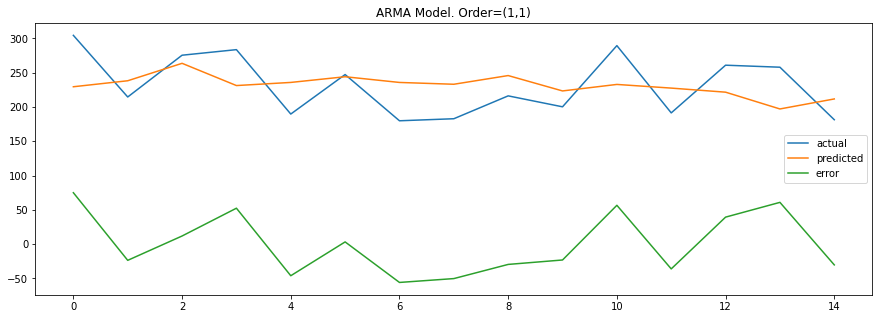

In [28]:
df_res.plot(figsize=(15,5),legend=True)
plt.title(msg);

## ARIMA

In [29]:
p=1; d=0; q=1
m2 = ARIMA(df_train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
print(m2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            Sales   No. Observations:                   33
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -172.958
Date:                          Tue, 24 May 2022   AIC                            357.916
Time:                                  09:02:48   BIC                            366.895
Sample:                              01-31-2014   HQIC                           360.937
                                   - 09-30-2016                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        229.7079      2.367     97.060      0.000     225.069     234.346
ar.L1          0.6619      0.223      2.974      0.

In [30]:
predictions = m2.predict(0,len(df_test)-1)
print(predictions)

Order Date
2014-01-31    229.707861
2014-02-28    238.116397
2014-03-31    262.522139
2014-04-30    231.856323
2014-05-31    236.307977
2014-06-30    244.459836
2014-07-31    236.816636
2014-08-31    234.709187
2014-09-30    247.834164
2014-10-31    226.826782
2014-11-30    237.813557
2014-12-31    234.672908
2015-01-31    216.562613
2015-02-28    174.619099
2015-03-31    227.994833
Freq: M, Name: predicted_mean, dtype: float64


In [31]:
actual = []; pred = []

for i in range(len(predictions)):
    actual.append(df_test[i])
    pred.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res1['error'] = df_res1.actual - df_res1.predicted
print(df_res1)

        actual   predicted      error
0   304.529311  229.707861  74.821450
1   214.626935  238.116397 -23.489463
2   275.565463  262.522139  13.043324
3   283.686284  231.856323  51.829961
4   189.730219  236.307977 -46.577759
5   247.362827  244.459836   2.902991
6   179.909045  236.816636 -56.907592
7   182.897150  234.709187 -51.812037
8   216.251942  247.834164 -31.582222
9   200.285027  226.826782 -26.541756
10  289.545358  237.813557  51.731801
11  191.430614  234.672908 -43.242294
12  260.996387  216.562613  44.433774
13  258.056264  174.619099  83.437165
14  181.448742  227.994833 -46.546091


In [32]:
msg1= 'ARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
mse1 = mean_squared_error(df_res1.actual, df_res1.predicted)
rmse1=np.sqrt(mse1)
print(msg1 + "\n\tMSE = {}".format(mse1))
print(msg1 + "\n\tRMSE = {}".format(rmse1))

ARIMA Model. Order=(1,0,1)
	MSE = 2297.1993049699763
ARIMA Model. Order=(1,0,1)
	RMSE = 47.92910707461569


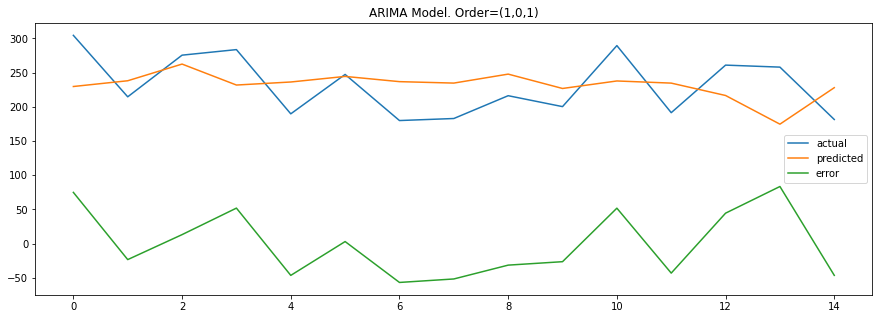

In [33]:
df_res1.plot(figsize=(15,5),legend=True)
plt.title(msg1);

## SARIMA

In [34]:
p=1; d=0; q=1
m3 = sm.tsa.statespace.SARIMAX(df_test,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()

In [35]:
predictions=m3.predict(0,len(df_test)-1)
print(predictions)

Order Date
2016-10-31      0.000000
2016-11-30    293.958454
2016-12-31    254.828357
2017-01-31    261.704104
2017-02-28    267.245761
2017-03-31    251.211872
2017-04-30    250.505750
2017-05-31    239.591679
2017-06-30    231.708794
2017-07-31    229.721500
2017-08-31    226.228797
2017-09-30    233.205295
2017-10-31    228.771349
2017-11-30    232.007800
2017-12-31    234.481455
Freq: M, Name: predicted_mean, dtype: float64


In [36]:
actual=[];pred=[]
    
for i in range(len(predictions)):
    actual.append(df_test[i])
    pred.append(predictions[i])

df_res2=pd.DataFrame({'actual':actual,'predicted':pred}) 
df_res2['error']=df_res2.actual-df_res2.predicted
print(df_res2)

        actual   predicted       error
0   304.529311    0.000000  304.529311
1   214.626935  293.958454  -79.331520
2   275.565463  254.828357   20.737107
3   283.686284  261.704104   21.982180
4   189.730219  267.245761  -77.515543
5   247.362827  251.211872   -3.849045
6   179.909045  250.505750  -70.596705
7   182.897150  239.591679  -56.694530
8   216.251942  231.708794  -15.456853
9   200.285027  229.721500  -29.436473
10  289.545358  226.228797   63.316561
11  191.430614  233.205295  -41.774681
12  260.996387  228.771349   32.225038
13  258.056264  232.007800   26.048464
14  181.448742  234.481455  -53.032713


In [37]:
mse2=mean_squared_error(df_res2.actual,df_res2.predicted)
print(msg1 + "\n\tMSE = {}".format(mse2))
rmse2=np.sqrt(mse2)
print(msg1 + "\n\tRMSE = {}".format(rmse2))

ARIMA Model. Order=(1,0,1)
	MSE = 8370.363299055442
ARIMA Model. Order=(1,0,1)
	RMSE = 91.48968957787234


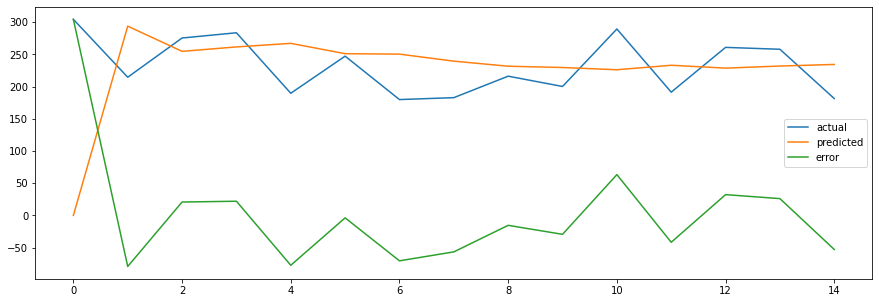

In [38]:
df_res2.plot(figsize=(15,5),legend=True);

In [39]:
p=1; d=0; q=1
m4 = sm.tsa.statespace.SARIMAX(sales,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
fcast = m4.predict(start=len(sales), end=len(sales)+11)
print(fcast)

2018-01-31    234.785048
2018-02-28    212.412735
2018-03-31    255.207419
2018-04-30    219.946553
2018-05-31    220.456793
2018-06-30    222.213169
2018-07-31    220.626980
2018-08-31    224.742347
2018-09-30    228.308919
2018-10-31    231.599066
2018-11-30    231.728400
2018-12-31    230.715952
Freq: M, Name: predicted_mean, dtype: float64


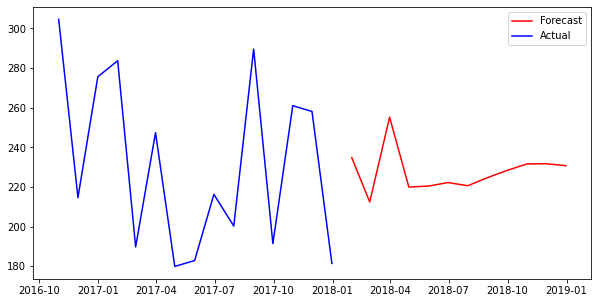

In [40]:
plt.figure(figsize=(10,5))
plt.plot(fcast, 'r', label = 'Forecast')
plt.plot(df_test, 'b', label='Actual')
plt.legend();

In [41]:
msee=[];rmsee=[];llr=[];aic=[];bic=[];hqic=[]
for x in [m1,m2,m3]:
    llr.append(x.llf)
    aic.append(x.aic)
    bic.append(x.bic)
    hqic.append(x.hqic)
    if (x==m1):
        msee.append(mse)
        rmsee.append(rmse)
    if (x==m2):
        msee.append(mse1)
        rmsee.append(rmse1)
    if (x==m3):
        msee.append(mse2)
        rmsee.append(rmse2) 

In [42]:
mod=pd.DataFrame(columns=['MSE','RMSE','LLR','AIC','BIC','HQIC'],index=['ARMA','ARIMA','SARIMA'])

mod['MSE']=msee
mod['RMSE']=rmsee
mod['LLR']=llr
mod['AIC']=aic
mod['BIC']=bic
mod['HQIC']=hqic

In [43]:
mod

,MSE,RMSE,LLR,AIC,BIC,HQIC
ARMA,1930.872386,43.941693,-173.402434,354.804869,360.790899,356.818986
ARIMA,2297.199305,47.929107,-172.958062,357.916124,366.895170,360.937300
SARIMA,8370.363299,91.489690,-81.177088,172.354176,175.894427,172.316465


##### On comparing all the models, SARIMA Model is best fit because:
- High Log Likelihood
- Low AIC
- Low BIC
- Low HQIC